# Neural Networks for Data Science Applications exam
## Second Homework: Experimenting with modularity in deep learning

**Name**: Emanuele De Bianchi

**Matricola**: 1861666

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

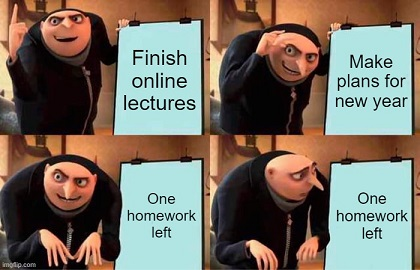

In [ ]:
import tensorflow as tf
import time

In [ ]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

For this homework I chose the dataset `smallnorb`, from the tensorflow's datasets available at [this link](https://www.tensorflow.org/datasets/catalog/smallnorb?hl=en). It is thought for 3D image recognition from shape and it contains images (sized 96 × 96 × 1) of 50 toys of five categories:


0.   four-legged animals,
1.   human figures,
2.   airplanes,
3.   trucks,
4.   cars.

The images were taken by two cameras under 6 lighting conditions, 9 elevations (30 to 70 degrees every 5 degrees), and 18 azimuths (0 to 340 every 20 degrees). Among all these features, by loading the dataset with `as_supervised=True`, you will obtain the pair composed by an image and the category label for each sample.
The dataset is divided into two splits, named `test` and `train`, each of 24,300 samples and I am splitting again the train split in order to have also some validation data.

For the entire homework I followed the paper *Convolutional Networks with Adaptive Inference Graphs (Andreas Veit, Serge Belongie)* that I found on the slides, adapting what they did for the dataset `cifar10` to my case.

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.
import tensorflow_datasets as tfds

train_data, val_data, test_data = tfds.load('smallnorb', as_supervised=True, split=['train[:80%]', 'train[80%:]', 'test'])

In [ ]:
train_data.element_spec

(TensorSpec(shape=(96, 96, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
import matplotlib.pyplot as plt

label: 4


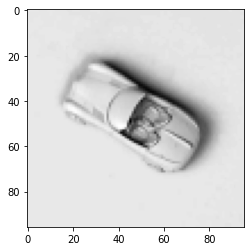

In [ ]:
for xb, yb in train_data:
  plt.imshow(xb[:, :, 0], cmap='gray')
  print(f'label: {yb}')
  break

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

For the preprocessing function I simply followed the procedure shown in the laboratory, while for the data augmentation I replicated what the authors of the paper did: pad 4 pixel on each side, random crop to the initial dimensions and then flip horizontally with probability $\frac12$. This would result, apart for the flipping, in cropping some pixels in any side and replacing them with black pixels.

For the model I implemented a ResNet, following the one explained in the book, in order to better highlight the impact of the modular version that I implemented in the second exercise. The model comprises an initial convolutional block, five residual blocks and then a classifier.
This model is then used for the image recognition task, where it receives in input an image and it decides to which category the toy in that image belongs.
For the training process I used the tensorflow functions `compile`, `fit` and `evaluate`. I chose the usual `SparseCategoricalCrossentropy` and `SparseCategoricalAccuracy` as loss function and metric, respectively, while for the optimizer I used `SGD` with a `momentum=0.9`.

In [ ]:
from tensorflow.keras import layers, regularizers, callbacks, losses

In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
def augment(image, label):
  batch_size = len(label)
  image = tf.image.pad_to_bounding_box(image, 4, 4, 104, 104)                   # add 4 pixels on each side (8 per dimension),
                                                                                # size becomes (96+8)x(96+8)=104x104
  image = tf.image.random_crop(image, size=(batch_size, 96, 96, 1))             # random crop to initial dimension
  image = tf.image.random_flip_left_right(image)                                # horizontally flip with probability 0.5
  return image, label

In [ ]:
batch_size = 32

In [ ]:
train_data_p = train_data.shuffle(1000).batch(batch_size).map(preprocess).map(augment)
val_data_p = val_data.batch(batch_size).map(preprocess)
test_data_p = test_data.batch(batch_size).map(preprocess)

In [ ]:
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=7,
                            restore_best_weights=True, verbose=1)
]

In [ ]:
class ResidualBlock(layers.Layer):

  def __init__(self, filters, strides=1, use_1x1=False):
    super().__init__()
    self.filters = filters
    self.strides = strides
    self.use_1x1 = use_1x1

  def build(self, input_shape):
    self.conv1 = layers.Conv2D(self.filters, kernel_size=3, padding='same',
                               strides=self.strides, kernel_regularizer=regularizers.L2(10e-3))
    self.bn1 = layers.BatchNormalization()
    self.conv2 = layers.Conv2D(self.filters, kernel_size=3, padding='same',
                               kernel_regularizer=regularizers.L2(10e-3))
    self.bn2 = layers.BatchNormalization()
    if self.use_1x1:
      self.conv = layers.Conv2D(self.filters, kernel_size=1, strides=self.strides)

  def call(self, x):
    if self.use_1x1:
      x_skip = self.conv(x)
    else:
      x_skip = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = tf.nn.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    return out + x_skip

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).

inp = layers.Input(shape=(96, 96, 1))

out = layers.Conv2D(32, kernel_size=7, strides=2, padding='same')(inp)
out = layers.BatchNormalization()(out)
out = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(out)

out = ResidualBlock(32)(out)
out = tf.nn.relu(out)
out = ResidualBlock(64, strides=2, use_1x1=True)(out)
out = tf.nn.relu(out)
out = ResidualBlock(128, strides=2, use_1x1=True)(out)
out = tf.nn.relu(out)
out = ResidualBlock(256, strides=2, use_1x1=True)(out)
out = tf.nn.relu(out)
out = ResidualBlock(512, strides=2, use_1x1=True)(out)
out = tf.nn.relu(out)

out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(80, activation='relu', kernel_regularizer=regularizers.L2(10e-3))(out)
out = layers.Dropout(0.4)(out)
out = layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(10e-3))(out)
out = layers.Dropout(0.2)(out)
out = layers.Dense(5, kernel_regularizer=regularizers.L2(10e-3))(out)

model = tf.keras.Model(inputs=inp, outputs=out)

In [ ]:
model.compile(loss=loss_fun, optimizer=optimizer, metrics=[accuracy])

In [ ]:
# You can train using fit() or a custom training loop, equivalently.
history = model.fit(train_data_p, validation_data=val_data_p, epochs=15, callbacks=cbs, verbose=0)

Restoring model weights from the end of the best epoch: 6.
Epoch 13: early stopping


✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

I am plotting the accuracy on the train data and over the validation data over the epochs through some graphs and then, using the evaluate `evaluate` function, I am printing the accuracy over the test data with the relative execution time.

In [ ]:
def print_accuracy(history, metric, title):
  plt.xlabel("epoch")
  plt.ylabel("accuracy (%)")
  plt.suptitle(title)
  plt.plot([val * 100 for val in history.history.get(metric)])

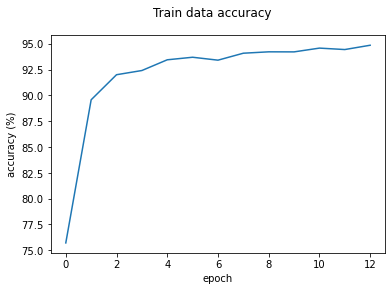

In [ ]:
print_accuracy(history, 'sparse_categorical_accuracy', 'Train data accuracy')

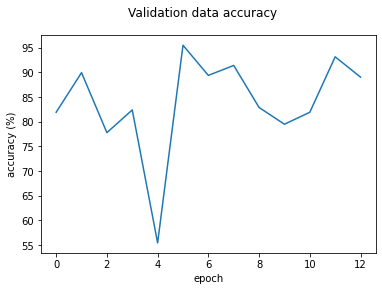

In [ ]:
print_accuracy(history, 'val_sparse_categorical_accuracy', 'Validation data accuracy')

In [ ]:
def print_eval(model, test_data):
  start = time.time()
  eval = model.evaluate(test_data, verbose=0)
  end = time.time()
  print(f'The accuracy on the test data is {eval[1] * 100:.2f}% with a loss of {eval[0]:.2f}')
  print(f'Inference execution time is of {end - start:.2f}s')

In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.
print_eval(model, test_data_p)

The accuracy on the test data is 84.24% with a loss of 0.85
Inference execution time is of 9.56s


### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

Here I followed the implementation of Veit and Belongie's article, where they propose a ResNet with **gated** residual blocks. The gate has the role of "deciding" whether to perform or not the layer to which it is applied, returning a truth value. During training the gate output is multiplyed by the residual block output, in order to perform all the computations that will provide the gradients, while during inference the layer is executed only if the gate "decides" so, in order to save computation time. We can express the overall behaviour during training as
$$x_l = x_{l-1} + g_l(x_{l-1}) \cdot f_l(x_{l-1})$$ and during inference as
$$
x_l = \begin{cases}
x_{l-1}, \qquad &\text{if}\ g_l(x_{l-1})=0 \\
x_{l-1} + f_l(x_{l-1}), \qquad &\text{if}\ g_l(x_{l-1})=1
\end{cases}
$$

where $l$ is the current layer and $x_{l-1}$ the output of the previous layer.
The training phase is the same as the previous case, as well as the model itself except for the gates applied on the residual blocks.

A relevant issue that I faced and that I resolved is that during inference it was not easy to split, within a single batch, those elements for which the layers has to be computed and those for which the gate decided to skip the layer. A possible solution for that is to choose a batch size of `1`, so with single elements no split has to be done and every image is treated by itself. The final solution I came up with finds all the elements in the batch for which the gate has computed `1` with the function `tf.where`, extract from the batch the corresponding images with `tf.gather`, apply the layer **only on those elements**, then "distribute" the output of the layer on the original batch size with `tf.scatter_nd` and finally sum the output of this process to the previous output in order to conclude the residual connection. Below I provided an example of this process on a $3 \times 3 \times 3$ tensor applying the function `func` on the first and third indiced of the first dimension.
This is performed by the `_separate` function inside the `GatedResidualBlock` class.

Here I've already prepared the model for the third exercise, but I am using only the components that are needed for this exercise. In the next exercise I'll show those ohter parts by simply setting the relative parameters.

In [ ]:
def func(x):
  return x*100

In [ ]:
x = tf.constant([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                 [[2, 2, 2], [2, 2, 2], [2, 2, 2]],
                 [[3, 3, 3], [3, 3, 3], [3, 3, 3]]])
g = tf.constant([1, 0, 1])
idx = tf.cast(tf.where(g), tf.int32)                                      # tf.Tensor([[0] [2]], shape=(2, 1))
to_be_exec = tf.reshape(tf.gather(x, idx), (2,3,3))                       # tf.Tensor([[[1 1 1]  [1 1 1]  [1 1 1]]
                                                                          #            [[3 3 3]  [3 3 3]  [3 3 3]]], shape=(2, 3, 3))
outs = func(to_be_exec)                                                   # tf.Tensor([[[100 100 100]  [100 100 100]  [100 100 100]]
                                                                          #            [[300 300 300]  [300 300 300]  [300 300 300]]], shape=(2, 3, 3))
outs_ord = tf.scatter_nd(idx, outs, tf.constant([3, 3, 3]))               # tf.Tensor([[[100 100 100]  [100 100 100]  [100 100 100]]
                                                                          #            [[  0   0   0]  [  0   0   0]  [  0   0   0]]
                                                                          #            [[300 300 300]  [300 300 300]  [300 300 300]]], shape=(3, 3, 3))
final = x + outs_ord
print(final)

tf.Tensor(
[[[101 101 101]
  [101 101 101]
  [101 101 101]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[303 303 303]
  [303 303 303]
  [303 303 303]]], shape=(3, 3, 3), dtype=int32)


Here I am building the gate layer, which computes the relevance score for the layer and then evaluates that score and decides whether to perform or not the layer to which it is applied. The relevance score is performed as a Global Average Pooling maintaining only the channel dimension and then two fully-connected layers connected with a Batch Normalization and a ReLU, $β = W_2 \cdot σ(W_1 \cdot z)$ where $z$ is the output of the Global Average Pooling. The vector $\beta$ has two components: the first is the score of computing the layer and the second is the score of skipping the layer, the highest score determines which action to perform.

In [ ]:
import tensorflow_probability as tfp

class Gate(layers.Layer):

  def __init__(self, temperature=1):
    super().__init__()
    self.gumbel = tfp.distributions.Gumbel(0, 1)
    self.temperature = temperature
    self.cnt = 1                                                                # I am using a counter to divide the temperature
                                                                                # by an increasing parameter in order to
                                                                                # decrease it every time it is used
  def build(self, input_shape):
    self.gap = layers.GlobalAveragePooling2D()
    self.dense1 = layers.Dense(16)
    self.bn = layers.BatchNormalization()
    self.relu = tf.nn.relu
    self.dense2 = layers.Dense(2)

  def call(self, x, training=False):
    x = self.gap(x)                                                             # the first part of the gate is the relevance estimator
    x = self.dense1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.dense2(x)                                                          # here we have in output the vector beta

    if training:                                                                # the second part simply performs the STE with the Gumbel trick
      soft_sample = tf.nn.softmax((x + self.gumbel.sample(tf.shape(x))) / (self.temperature/self.cnt))
      self.cnt += 1
      hard_sample = tf.stop_gradient(tf.one_hot(tf.argmax(soft_sample, -1), 2))
      return hard_sample - tf.stop_gradient(soft_sample) + soft_sample
    else:
      return tf.stop_gradient(tf.one_hot(tf.argmax(x, -1), 2))

In [ ]:
for xb, yb in train_data_p:
  break

In [ ]:
g = Gate()
print(g(xb, training=True).shape)
print(g(xb, training=False).shape)

(32, 2)
(32, 2)


`Gate` output has shape `(batch_size, 2)` in both cases of training and inference

Now I'm building the gated residual block by inheriting from the ResidualBlock class that I wrote before and adding a gate and an `if` statement in order to split the cases when the model is training and when it is performing inference.

In [ ]:
class GatedResidualBlock(ResidualBlock):

  def __init__(self, filters, strides=1, use_1x1=False):
    super().__init__(filters, strides, use_1x1)

  def build(self, input_shape):
    self.gate = Gate(temperature=1)

    self.conv1 = layers.Conv2D(self.filters, kernel_size=3, padding='same',
                               strides=self.strides, kernel_regularizer=regularizers.L2(10e-3))
    self.bn1 = layers.BatchNormalization()
    self.conv2 = layers.Conv2D(self.filters, kernel_size=3, padding='same',
                               kernel_regularizer=regularizers.L2(10e-3))
    self.bn2 = layers.BatchNormalization()
    if self.use_1x1:
      self.conv = layers.Conv2D(self.filters, kernel_size=1, strides=self.strides)

  def _execute_layer(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = tf.nn.relu(out)
    out = self.conv2(out)
    return self.bn2(out)

  def _separate(self, x, x_skip, gate_res):                                     # this function performs the procedure in the example
    idx = tf.cast(tf.where(gate_res), tf.int32)                                 # indices of nonzero components
    ones = len(idx)                                                             # number of nonzero components
    if ones == 0:
      return x_skip                                                             # if the gate_res are all 0's, just do nothing

    shape_x = tf.shape(x)
    to_be_exec = tf.reshape(tf.gather(x, idx),                                  # here I had to do some tricks because gather gives some strange shapes
                            (ones, shape_x[1], shape_x[2], shape_x[3]))
    outs = self._execute_layer(to_be_exec)
    outs_ord = tf.scatter_nd(idx, outs, tf.shape(x_skip))
    return x_skip + outs_ord                                                    # sum only on the components for which gate_res != 0

  def call(self, x, training=False):
    if self.use_1x1:
      x_skip = self.conv(x)
    else:
      x_skip = x

    gate_res = self.gate(x, training)[:, 0]                                     # taking only the first component I can use it as a truth value
                                                                                # for the execution of the layer
    if training:
      out = self._execute_layer(x)
      gate_res_factor = tf.reshape(gate_res, (-1, 1, 1, 1))                     # reshape needed for the broadcasting
      return gate_res_factor * out + x_skip, gate_res
    else:
      return self._separate(x, x_skip, gate_res), gate_res

In [ ]:
gc = GatedResidualBlock(32, use_1x1=True)
x, g = gc(xb, training=True)
print(x.shape, g.shape)
x, g = gc(xb, training=False)
print(x.shape, g.shape)

(32, 96, 96, 32) (32,)
(32, 96, 96, 32) (32,)


`GatedResidualBlock` has two outputs, of shape `(batch_size, k, k, filters)` and `(batch_size, 1)` in both cases

In [ ]:
class EarlyExitModel(tf.keras.Model):

  def __init__(self, use_rate_loss=False):
    super().__init__()
    self.use_rate_loss = use_rate_loss

    self.conv = layers.Conv2D(32, kernel_size=7, strides=2, padding='same')
    self.bn = layers.BatchNormalization()
    self.mp = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

    self.resblock1 = GatedResidualBlock(32)
    self.resblock2 = GatedResidualBlock(64, strides=2, use_1x1=True)
    self.resblock3 = GatedResidualBlock(128, strides=2, use_1x1=True)
    self.resblock4 = GatedResidualBlock(256, strides=2, use_1x1=True)
    self.resblock5 = GatedResidualBlock(512, strides=2, use_1x1=True)

    self.gap = layers.GlobalAveragePooling2D()
    self.dense1 = layers.Dense(80, activation='relu', kernel_regularizer=regularizers.L2(10e-3))
    self.drop1 = layers.Dropout(0.4)
    self.dense2 = layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(10e-3))
    self.drop2 = layers.Dropout(0.2)
    self.dense3 = layers.Dense(5, kernel_regularizer=regularizers.L2(10e-3))

  def call(self, x, training=False):
    x = self.conv(x)
    x = self.bn(x)
    x = self.mp(x)

    gate_outs = []
    x, g = self.resblock1(x, training)
    x = tf.nn.relu(x)
    gate_outs.append(tf.reshape(g, (-1, 1)))

    x, g = self.resblock2(x, training)
    x = tf.nn.relu(x)
    gate_outs.append(tf.reshape(g, (-1, 1)))

    x, g = self.resblock3(x, training)
    x = tf.nn.relu(x)
    gate_outs.append(tf.reshape(g, (-1, 1)))

    x, g = self.resblock4(x, training)
    x = tf.nn.relu(x)
    gate_outs.append(tf.reshape(g, (-1, 1)))

    x, g = self.resblock5(x, training)
    x = tf.nn.relu(x)
    gate_outs.append(tf.reshape(g, (-1, 1)))

    x = self.gap(x)
    x = self.dense1(x)
    x = self.drop1(x)
    x = self.dense2(x)
    x = self.drop2(x)
    if self.use_rate_loss:
      return self.dense3(x), tf.concat(gate_outs, 1)                            # for the rate loss I need the gates' activation rates
    else:
      return self.dense3(x)

In [ ]:
eem = EarlyExitModel()
x = eem(xb, training=True)
print(x.shape)
x = eem(xb, training=False)
print(x.shape)

(32, 5)
(32, 5)


`EarlyExitModel` has an output shaped `(5, 1)`, that is `(num_classes, 1)` where the classes are the ones to which the toys belong.

In [ ]:
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.
model2 = EarlyExitModel()
model2.compile(loss=loss_fun, optimizer=optimizer, metrics=[accuracy])

In [ ]:
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=7,
                            restore_best_weights=True, verbose=1)
]

In [ ]:
history2 = model2.fit(train_data_p, validation_data=val_data_p, epochs=15, callbacks=cbs, verbose=0)

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

Here I am plotting and printing the metrics as in the previous case, you can notice that the test data accuracy has increased, while the execution time has slighly worsened.

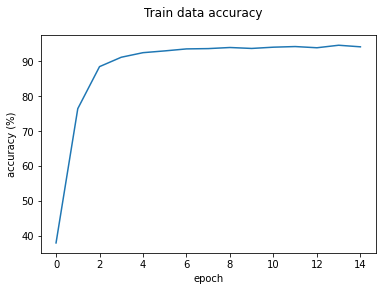

In [ ]:
# TODO: Add results here (anything appropriate is okay).
print_accuracy(history2, 'sparse_categorical_accuracy', 'Train data accuracy')

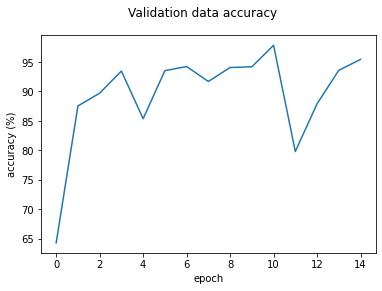

In [ ]:
print_accuracy(history2, 'val_sparse_categorical_accuracy', 'Validation data accuracy')

In [ ]:
print_eval(model2, test_data_p)

The accuracy on the test data is 86.72% with a loss of 0.80
Inference execution time is of 10.29s


### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

Here I am again following the article of Veit and Belongie, where they propose a layer rate loss, whoch aims to regularize the execution rate of the gated layers. This loss is computed using the activation rates of the layers during training (that is the output of the gates over the entire batch) and comparing it with respect to a target execution rate, which can be uniform or layer-specific. The loss has two terms, the classification term could be any known classification loss, $\mathcal{L}_{class}$, (I am using again the `SparseCategoricalCrossentropy`), while the rate loss is defined as
$$
\mathcal{L}_{rate} = \frac{1}{\lvert L \rvert} \sum_{l \in L} \left ( \frac{1}{\lvert B \rvert} \sum_{i \in B} g_{l, i} - t_l\right )^2.
$$

The overall cost is a weighted sum of those two components, as
$$
\mathcal{L} = \mathcal{L}_{class} + \lambda \cdot \mathcal{L}_{rate}
$$
where the chosen weight is $\lambda=2$.

In order to compute the loss on the gate activation rates I am returning in output all the gate activations in order to compute that loss on them.

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.
from keras.utils import losses_utils as lu

class LayerRateLoss(losses.Loss):

  def __init__(self, target_rates, reduction=lu.ReductionV2.AUTO, name=None):
    super().__init__(reduction=reduction, name=name)
    self.target_rates = target_rates

  def call(self, y_true, gate_activations):
    return tf.reduce_mean(tf.square(tf.reduce_mean(gate_activations, 0) - self.target_rates))

In [ ]:
target_rates = tf.constant([0.3, 0.25, 0.2, 0.15, 0.1])                         # I am normalizing in order to "use" mainly the
my_loss_fun = LayerRateLoss(target_rates)                                       # first layers and less the last ones

In [ ]:
eem = EarlyExitModel(use_rate_loss=True)
x, g = eem(xb, training=True)
print(x.shape, g.shape)
x, g = eem(xb, training=False)
print(x.shape, g.shape)

(32, 5) (32, 5)
(32, 5) (32, 5)


`EarlyExitModel` now has two output, both shaped `(5, 1)`. Actually this is a coincidence that I took advantage of, because five is both the number of classes in the recognition task and the number of gated layers I implemented, so the outputs have respectively the shapes `(num_classes, 1)` and `(num_layers, 1)`.

In [ ]:
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
model3 = EarlyExitModel(use_rate_loss=True)
model3.compile(loss=[loss_fun, my_loss_fun], loss_weights=[1.0, 2.0], optimizer=optimizer, metrics=[accuracy])

In [ ]:
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_output_1_sparse_categorical_accuracy', patience=7,
                            restore_best_weights=True, verbose=1)
]

In [ ]:
history3 = model3.fit(train_data_p, validation_data=val_data_p, epochs=15, callbacks=cbs, verbose=0)

Restoring model weights from the end of the best epoch: 7.
Epoch 14: early stopping


✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

Also in this case I am using the graphs and the accuracy and execution time over the test data, with respect to the previous case - thanks to the layer rate loss - the execution time has further decreased, while the test data accuracy has increased a lot.

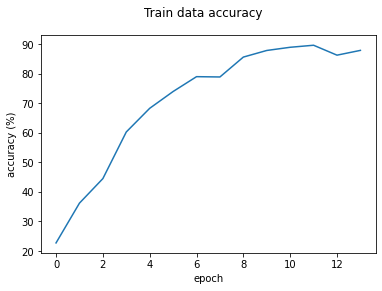

In [ ]:
# TODO: Add results here (anything appropriate is okay).
print_accuracy(history3, 'output_1_sparse_categorical_accuracy', 'Train data accuracy')

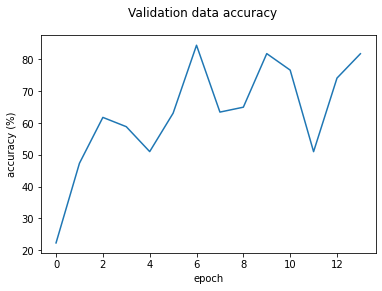

In [ ]:
print_accuracy(history3, 'val_output_1_sparse_categorical_accuracy', 'Validation data accuracy')

In [ ]:
print_eval(model3, test_data_p)

The accuracy on the test data is 93.62% with a loss of 1.58
Inference execution time is of 8.29s


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

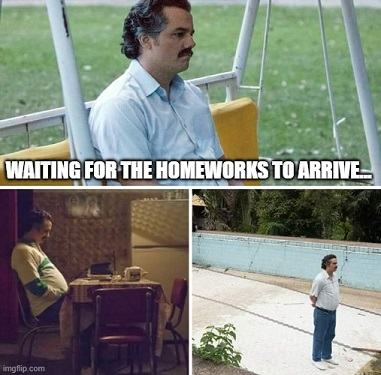